Traffic Sign Classification

This notebook showcases the developed Traffic Sign Recognition model, over the GTSRB - German Traffic Sign dataset, using PyTorch. The goal is to provide a clear way to visualize and explain the code. This way, we'll go over multiple sections:

1) <a href="#dp">Data Profiling</a>
2) <a href="#md">Model Definition and Profiling</a>
3) <a href="#bmt">Base Model Training</a>
4) <a href="#bme">Base Model Evaluation</a>
5) <a href="#tmd">Transformer Definition and Profiling</a>
6) <a href="#tmt">Transformer Training</a>
7) <a href="#tme">Transformer Evaluation</a>
9) <a href="#mcpdp">Model Comparison Pre Data Preparation</a>
9) <a href="#dprep">Data Preparation (Augmentation, CLAHE, etc...)</a>
10) Model Comparison Post Data Preparation
11) <a href="#ap">Appendix</a>
    
For the first approach, we're going to train and test a CNN and a Vision Transformer without applying data preparation to the dataset. Then, we'll augment the data and apply [CLAHE](https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/) and Data Augmentation to balance the dataset, and evaluate the performance evolution.

<a id='dp'></a>
### 1. Data Profiling

Loading serialized data for data profiling, using pickle since JSON creates much larger file sizes. Images are set to 32 by 32 pixels, with 3 channels.

In [2]:
import codecs, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle

num_classes = 43
IMAGE_SIZE = 32

# Loading data for visualization
train_data = pickle.load(open("serialized_data/train_data_numpy", "rb"))
train_labels = pickle.load(open("serialized_data/train_labels_numpy", "rb"))
test_data = pickle.load(open("serialized_data/test_data_numpy", "rb"))

# Loading number-to-name label conversion json
label_json = codecs.open("DataProfiling/label_names.json", 'r', encoding='utf-8').read()
label_names = json.loads(label_json)

Dataset statistics and preview:


Shape of training data:  (39209, 32, 32, 3)
Shape of test data:  (12630, 32, 32, 3)
Number of classes: 43
Images resized to 32 x 32


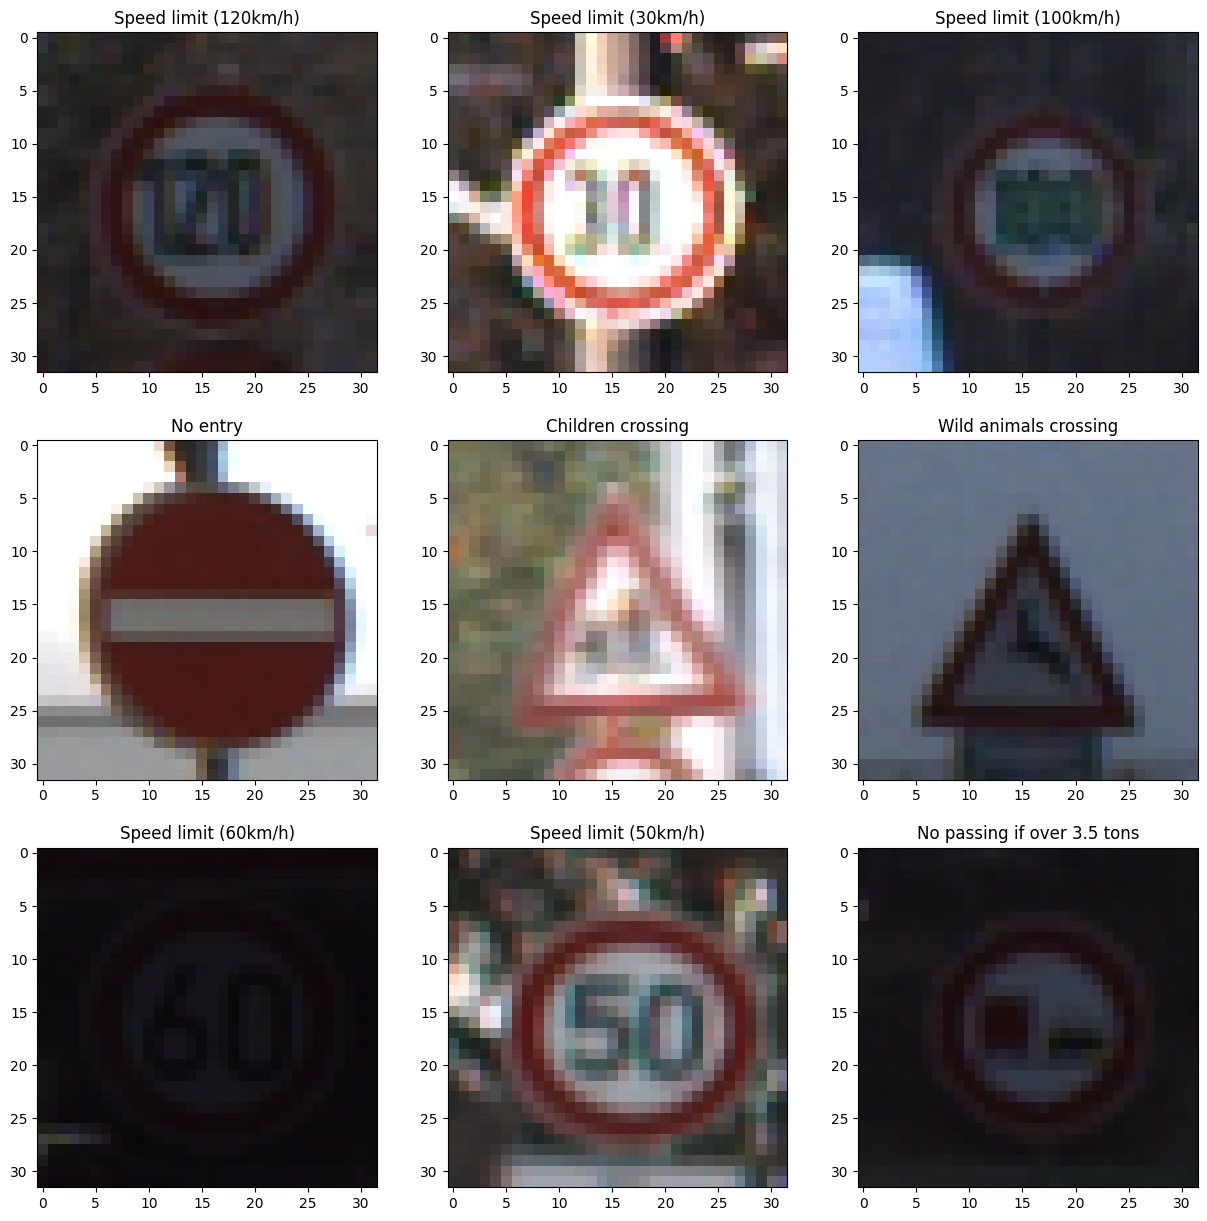

In [3]:
print("\nShape of training data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)
print(f"Number of classes: {num_classes}")
print(f"Images resized to {IMAGE_SIZE} x {IMAGE_SIZE}")

# Plotting random train set examples
plot_size = 3
random_idxs = [random.randint(0, train_data.shape[0]) for i in range(plot_size**2)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_idxs):
    a=fig.add_subplot(plot_size,plot_size, i+1)
    imgplot = plt.imshow(train_data[index])
    a.set_title(label_names[str(train_labels[index]+1)])
plt.show()

The dataset in heavily unbalanced, with some classes having only around 200 instances and others having more than 2000, as be seen in the class distribution histogram below. This issue can have a significant impact on model performance and is addressed through data augmentation and oversampling .

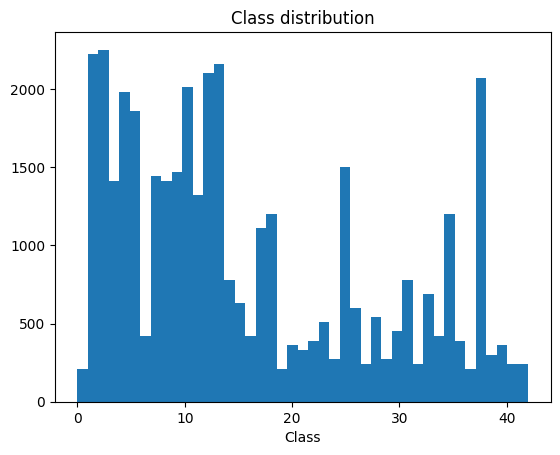

In [4]:
fig, ax = plt.subplots()
values, bins, patches = ax.hist(train_labels, num_classes)
ax.set_xlabel('Class')
ax.set_title('Class distribution')
plt.show()

<a id="md"></a>
### 2. Model Definition and Profiling:

The architecture of the model is loosely based on [AlexNet](https://en.wikipedia.org/wiki/AlexNet), consisting of multiple convolution layers, some followed by max pooling, and mostly using the [ELU](https://deeplearninguniversity.com/elu-as-an-activation-function-in-neural-networks/) activation function. This is followed by a fully connected network, with 2 hidden layers (using RELU) and dropout regularization with p=0.5 to reduce overfitting. Multiple hypermeter variations were tested, with the current one leading to the best performance.

In [5]:
import torch.nn as nn

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes, clahe=False):
        super().__init__()
        input_n = 1 if clahe else 3
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_n, out_channels=64, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3,padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
        )
        
        self.classification = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*256, 600),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=600, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        X = self.conv(x)
        X = X.view(X.shape[0], -1)
        Y = self.classification(X)
        return Y

<a id='bmt'></a>
### 3. Base Model Training:

To train the model, cross entropy loss showed the best results, using adam optimization for efficiency with a constant learning rate of 0.001. The batch size chosen is 256 examples.

In [7]:
from model import TrafficSignCNN
from torch import optim, nn, save
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from matplotlib.pyplot import Axes, gca, figure, savefig
from torch.utils.data import DataLoader
import pickle

# Loading training dataset
train_set = pickle.load(open("serialized_data/train_data_loader", "rb"))

# Parameters 
num_classes = 43
batch_size = 256
learning_rate = 0.001
EPOCHS = 15

# Train function
def train(model, train_set, optimizer, criterion):
    epoch_ls = 0
    epoch_acc = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_set):
        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        final_pred = y_pred.argmax(axis=1)
        accuracy = accuracy_score(final_pred,y)
        optimizer.step()
        epoch_ls += loss.item()
        epoch_acc += accuracy
    return epoch_ls / len(train_set), epoch_acc / len(train_set)

# Initializing CNN, Loss function, and optimizer
model = TrafficSignCNN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Main training logic
train_loss = []
train_accuracy = []
for epoch in range(EPOCHS):
    print("Epoch: ",epoch)
    train_ls, train_acc = train(model, train_set, optimizer, criterion)
    train_loss.append(train_ls)
    train_accuracy.append(train_acc)
    print("Loss: ",train_ls)
    print("Accuracy: ",train_acc)
    
save(model.state_dict(), "serialized_data/model.pt")

Epoch:  0
Loss:  2.6926843624610406
Accuracy:  0.2319869535951853
Epoch:  1
Loss:  0.7892932531895576
Accuracy:  0.7366714840038011
Epoch:  2
Loss:  0.25004737882258055
Accuracy:  0.9174366982103263
Epoch:  3
Loss:  0.12085181694816459
Accuracy:  0.9613878880266075
Epoch:  4
Loss:  0.07252120335477513
Accuracy:  0.9763026607538803
Epoch:  5
Loss:  0.06245402469263448
Accuracy:  0.9804056461830851
Epoch:  6
Loss:  0.056072249373590406
Accuracy:  0.9827708019876464
Epoch:  7
Loss:  0.04896799164110577
Accuracy:  0.9839122386759581
Epoch:  8
Loss:  0.04727801381060007
Accuracy:  0.9852374188311688
Epoch:  9
Loss:  0.048874052510560526
Accuracy:  0.9849076704545454
Epoch:  10
Loss:  0.038408775672894094
Accuracy:  0.9883066152597403
Epoch:  11
Loss:  0.0488428602270274
Accuracy:  0.9848823051948052
Epoch:  12
Loss:  0.03389363716297493
Accuracy:  0.9906909496753247
Epoch:  13
Loss:  0.03165929220380963
Accuracy:  0.9903865665584416
Epoch:  14
Loss:  0.041601952490420986
Accuracy:  0.989182

Plotting loss and accuracy over time:

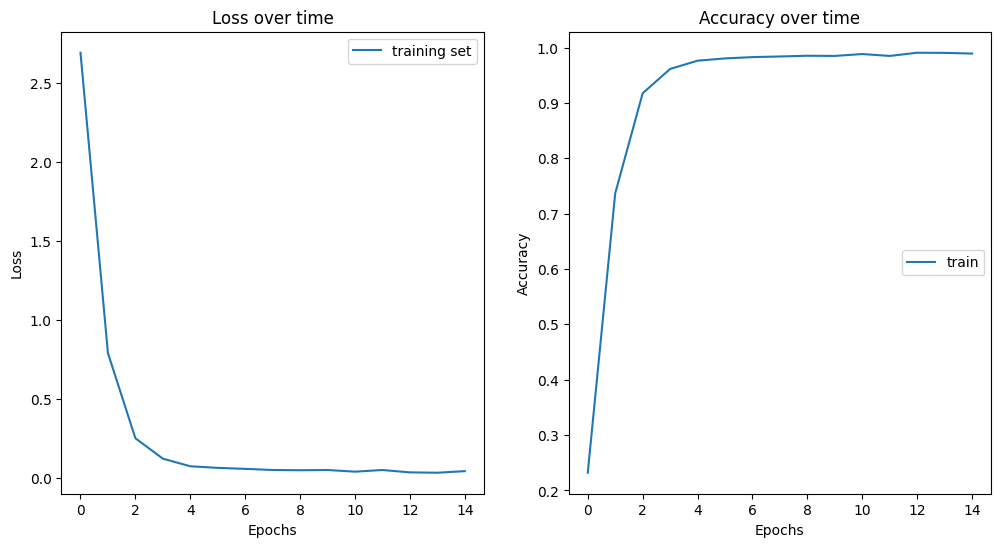

In [8]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(train_loss, label="training set")
axs[0].set_title("Loss over time")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right')
axs[1].plot(train_accuracy, label="train")
axs[1].set_title("Accuracy over time")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right')
plt.show()

A training accuracy of 0.98 is achieved in just 15 epochs. The loss reaches a very small values within just a few iterations, finishing at 0.036. 

<a id='bme'></a>
### 4. Base Model Evaluation:

The test set evaluation of the model reaches an accuracy of 0.95, correctly classifying 12044 images:

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch

# Loading test dataset
test_set = pickle.load(open("serialized_data/test_data_loader", "rb"))

true_labels = []
pred_labels = []

# Testing
with torch.no_grad():
    model.eval()
    y_right = 0
    for idx, (x, y) in enumerate(test_set):
        y_pred = model(x)
        final_pred = y_pred.argmax(axis=1)
        if y.item() == final_pred.item():
            y_right += 1
        pred_labels.append(final_pred.item())
        true_labels.append(y.item())

print(f"Correctly classified images: {y_right}")
print(f"Incorrectly classified images: {len(test_set)-y_right}")
print(f"Final Model Accuracy: {y_right/len(test_set)}")
print(classification_report(true_labels,pred_labels))

Correctly classified images: 11955
Incorrectly classified images: 675
Final Model Accuracy: 0.9465558194774347
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        60
           1       0.98      0.96      0.97       720
           2       0.96      0.98      0.97       750
           3       0.92      0.95      0.94       450
           4       0.94      0.98      0.96       660
           5       0.86      0.93      0.89       630
           6       0.99      0.86      0.92       150
           7       0.96      0.94      0.95       450
           8       0.98      0.93      0.95       450
           9       0.99      0.96      0.97       480
          10       0.98      0.99      0.98       660
          11       0.91      0.97      0.94       420
          12       0.97      0.96      0.96       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      1.00       270
          15       0.99 

Confusion Matrix: 

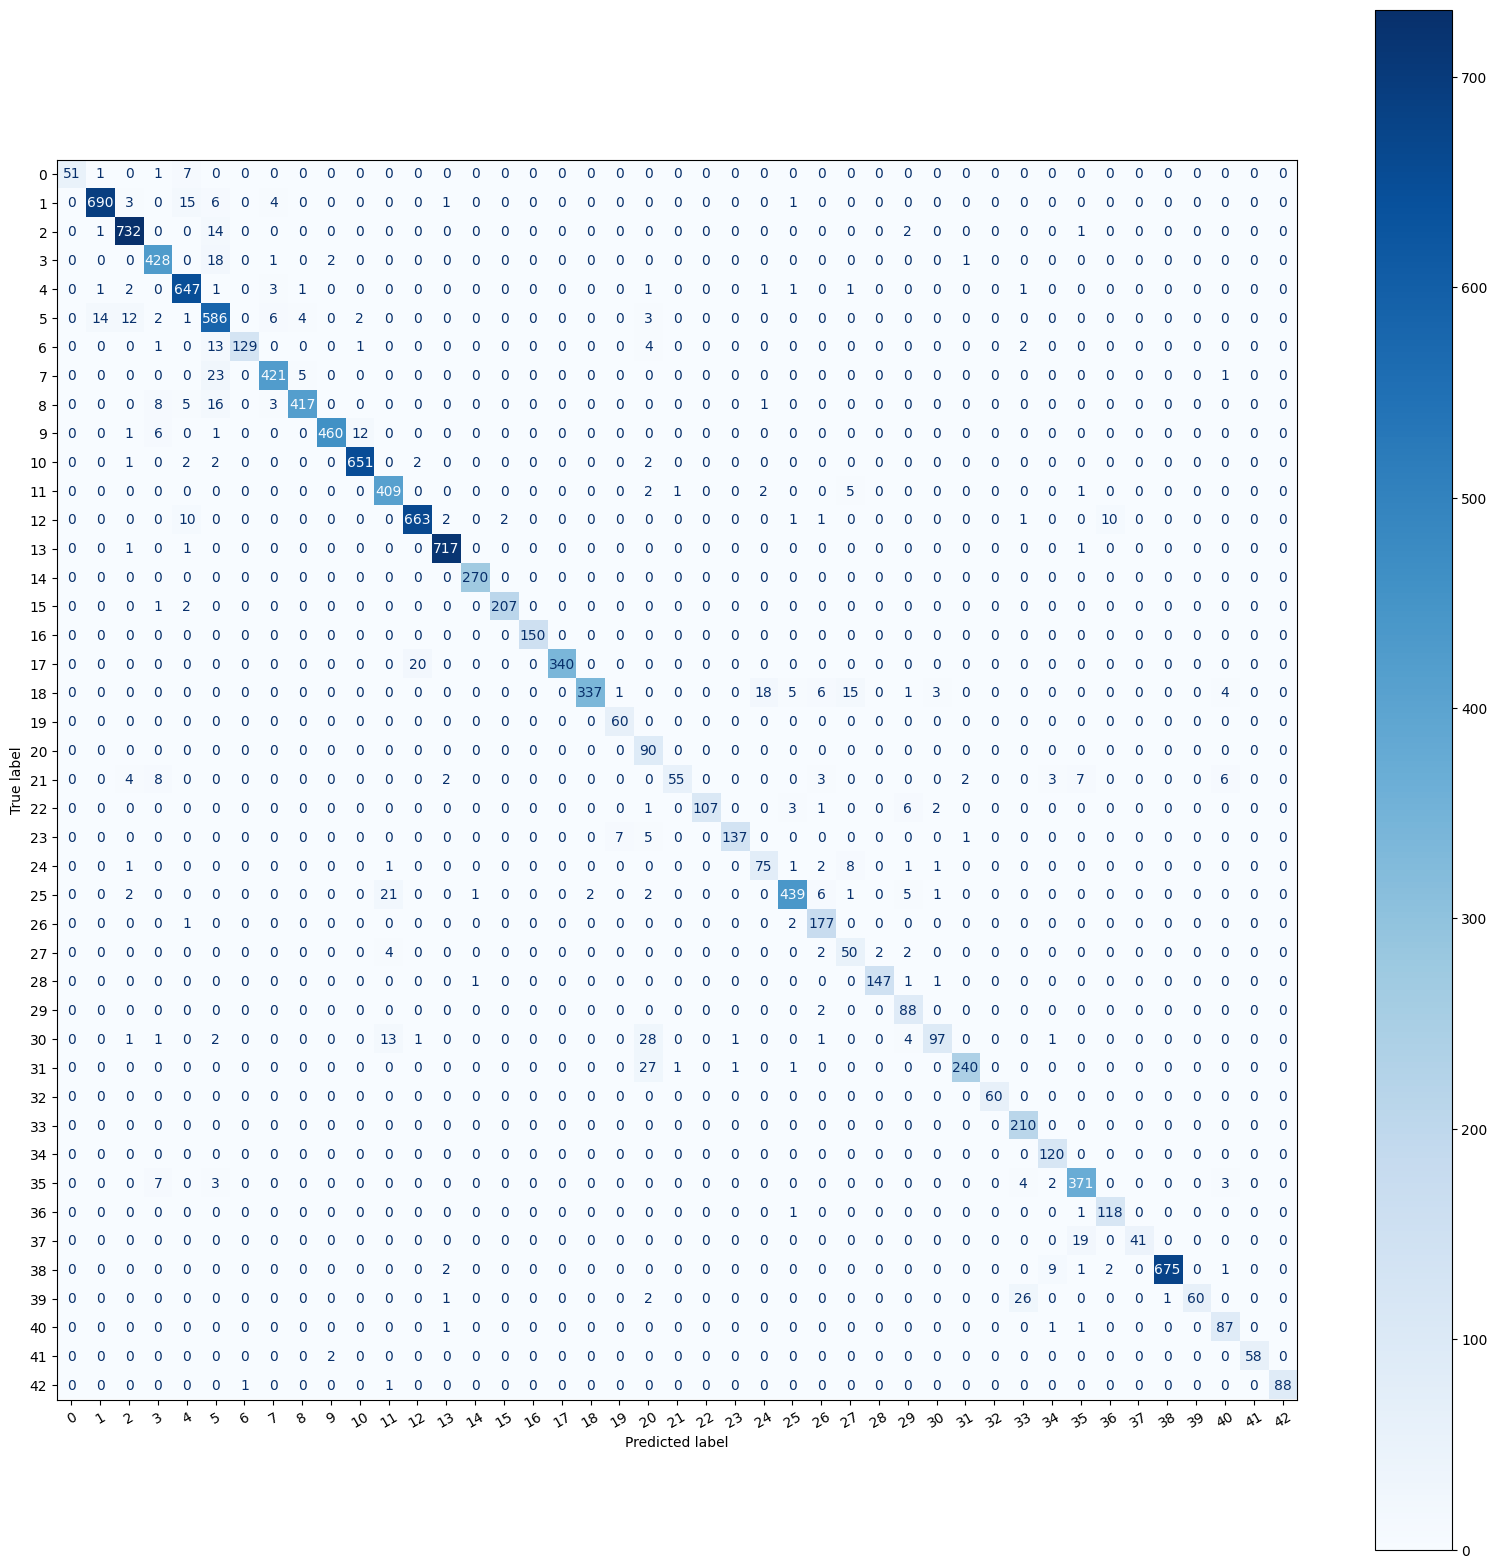

In [10]:
fig = plt.figure(figsize = (20, 20));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(true_labels, pred_labels);
cm = ConfusionMatrixDisplay(cm, display_labels = range(0, num_classes));
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 30)
plt.show()

To show some examples of predictions, randomly selected images and results are presented:

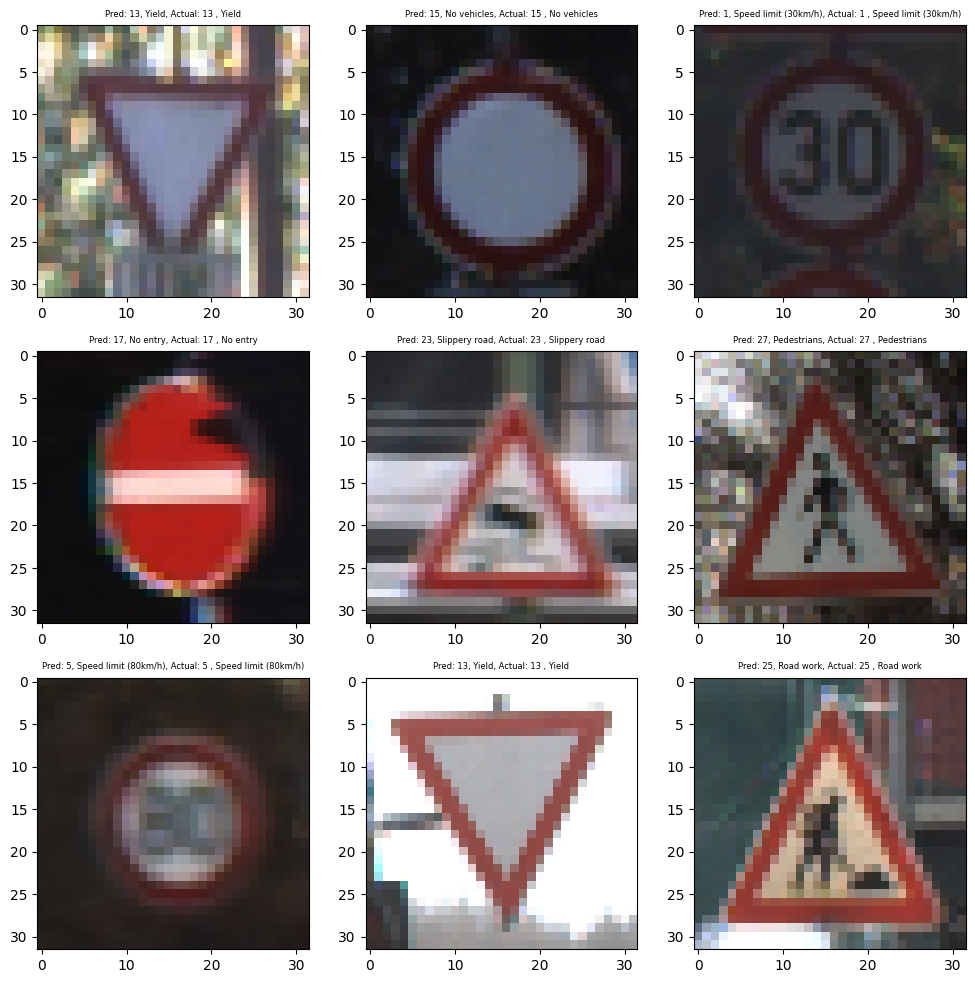

In [20]:
from random import randrange
import pickle
import cv2
import matplotlib.pyplot as plt

# Getting random images
num_imgs = 9
random_idxs = [randrange(0,len(test_set)) for i in range(num_imgs)]
imgs = [test_set.dataset.__getitem__(random_idxs[i])[0] for i in range(num_imgs)]

# Calculating plot grid
HEIGHT = 4
NR_COLUMNS = 3
grid = (1,num_imgs)
if num_imgs > NR_COLUMNS:
    grid = (num_imgs // NR_COLUMNS, NR_COLUMNS) if num_imgs % NR_COLUMNS == 0 else (num_imgs // NR_COLUMNS + 1, NR_COLUMNS)

# Plotting images with respective class and prediction
i, j = 0, 0
fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1]*HEIGHT,grid[0]*HEIGHT))
for n in range(num_imgs):
    img = imgs[n]
    axs[i, j].imshow(img.numpy().transpose(1,2,0))
    title = f"Pred: {pred_labels[random_idxs[n]]}, {label_names[str(pred_labels[random_idxs[n]]+1)]}, Actual: {true_labels[random_idxs[n]]} , {label_names[str(true_labels[random_idxs[n]]+1)]}"
    axs[i, j].set_title(title, fontsize=6)
    i, j = (i + 1, 0) if (n+1) % grid[1] == 0 else (i, j + 1)

<a id='tmd'></a>
### 5. Transformer Model Definition

To train the Vision Transformer, we use 128x128 images, with patches of 16x16.

In [22]:
from vit_pytorch import ViT

if torch.cuda.is_available(): 
    device = "cuda:0"
else:
    device = "cpu"

transformer = ViT(
    image_size = 128,
    patch_size = 16,
    num_classes = num_classes,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

<a id='tmt'></a>
### 6. Transformer Training

In [53]:
# Loading training dataset
train_set_vit = pickle.load(open("serialized_data/train_data_loader", "rb")) 

# Parameters 
learning_rate = 0.001
EPOCHS = 5

# Train function
def train(model, train_set, optimizer, criterion):
    epoch_ls = 0
    epoch_acc = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_set):
        x.to(device)
        y.to(device)
        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        final_pred = y_pred.argmax(axis=1)
        accuracy = accuracy_score(final_pred,y)
        optimizer.step()
        epoch_ls += loss.item()
        epoch_acc += accuracy
    return epoch_ls / len(train_set), epoch_acc / len(train_set)

# Initializing Loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)

# Main training logic
train_loss = []
train_accuracy = []
for epoch in range(EPOCHS):
    print("Epoch: ",epoch)
    train_ls, train_acc = train(transformer, train_set_vit, optimizer, criterion)
    train_loss.append(train_ls)
    train_accuracy.append(train_acc)
    print("Loss: ",train_ls)
    print("Accuracy: ",train_acc)
    
save(model.state_dict(), "serialized_data/transformer.pt")

Epoch:  0
Loss:  0.2852116578875424
Accuracy:  0.912426750079189
Epoch:  1
Loss:  0.19224354871488236
Accuracy:  0.9365998426116565
Epoch:  2
Loss:  0.17796618143072376
Accuracy:  0.9416982598194488
Epoch:  3
Loss:  0.17019926775972566
Accuracy:  0.9442285991447578
Epoch:  4
Loss:  0.1585556724919127
Accuracy:  0.9473355341305036


<a id='tme'></a>
### 7. Transformer Evaluation

In [59]:
# Loading test dataset
test_set = pickle.load(open("serialized_data/test_data_loader", "rb"))

true_labels = []
pred_labels = []

# Testing
with torch.no_grad():
    transformer.eval()
    y_right = 0
    for idx, (x, y) in enumerate(test_set):
        y_pred = transformer(x)
        final_pred = y_pred.argmax(axis=1)
        if y.item() == final_pred.item():
            y_right += 1
        pred_labels.append(final_pred.item())
        true_labels.append(y.item())

print(f"Correctly classified images: {y_right}")
print(f"Incorrectly classified images: {len(test_set)-y_right}")
print(f"Final Model Accuracy: {y_right/len(test_set)}")
print(classification_report(true_labels,pred_labels))

Correctly classified images: 10086
Incorrectly classified images: 2544
Final Model Accuracy: 0.7985748218527315
              precision    recall  f1-score   support

           0       0.73      0.37      0.49        60
           1       0.75      0.90      0.82       720
           2       0.68      0.94      0.79       750
           3       0.74      0.52      0.61       450
           4       0.82      0.73      0.78       660
           5       0.68      0.66      0.67       630
           6       0.89      0.45      0.60       150
           7       0.62      0.85      0.72       450
           8       0.67      0.89      0.76       450
           9       0.91      0.81      0.86       480
          10       0.87      0.90      0.88       660
          11       0.90      0.82      0.86       420
          12       0.95      0.83      0.89       690
          13       0.96      0.98      0.97       720
          14       0.81      0.99      0.89       270
          15       0.92

Confusion Matrix:

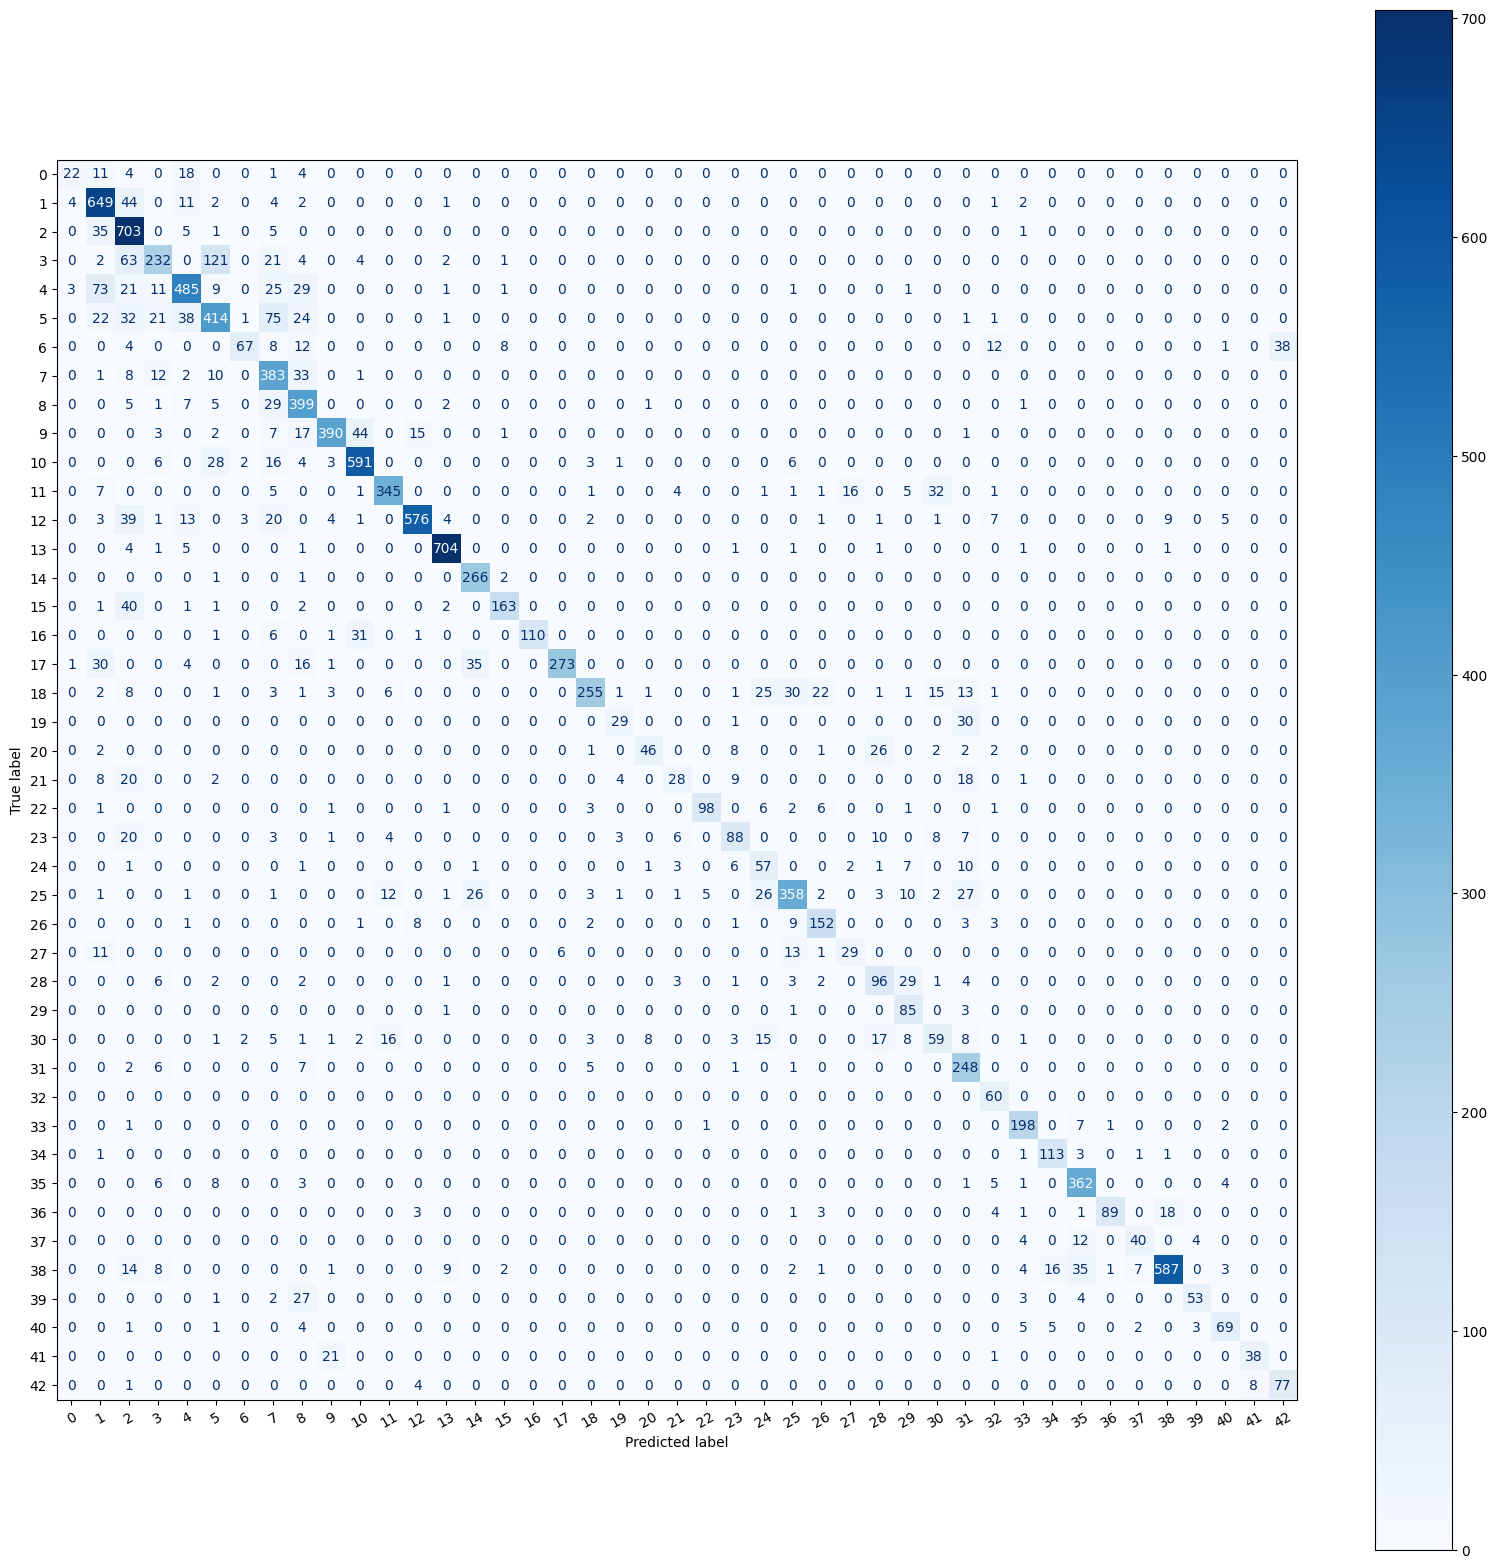

In [60]:
fig = plt.figure(figsize = (20, 20));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(true_labels, pred_labels);
cm = ConfusionMatrixDisplay(cm, display_labels = range(0, num_classes));
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 30)
plt.show()

Examples of the same random images and their predictions:

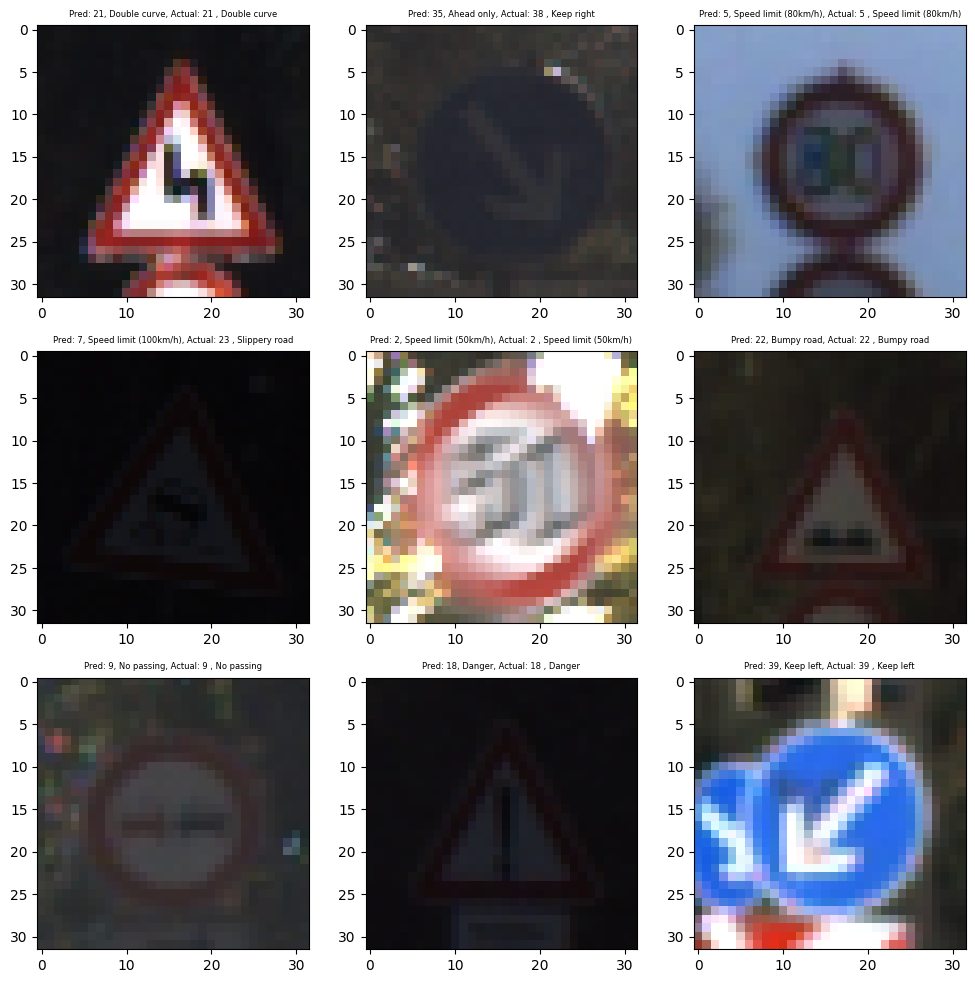

In [61]:
# Plotting images with respective class and prediction
random_idxs = [randrange(0,len(test_set_vit)) for i in range(num_imgs)]
imgs = [test_set_vit.dataset.__getitem__(random_idxs[i])[0] for i in range(num_imgs)]

i, j = 0, 0
fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1]*HEIGHT,grid[0]*HEIGHT))
for n in range(num_imgs):
    img = imgs[n]
    axs[i, j].imshow(img.numpy().transpose(1,2,0))
    title = f"Pred: {pred_labels[random_idxs[n]]}, {label_names[str(pred_labels[random_idxs[n]]+1)]}, Actual: {true_labels[random_idxs[n]]} , {label_names[str(true_labels[random_idxs[n]]+1)]}"
    axs[i, j].set_title(title, fontsize=6)
    i, j = (i + 1, 0) if (n+1) % grid[1] == 0 else (i, j + 1)

<a id='mcpdp'></a>
### 8. Model Comparison Pre Data Preparation

<a id='dprep'></a>
### 9. Data Preparation

#### Balancing

#### CLAHE

Loading the clahe dataset. Check the [Appendix](#ap) for the data transformation code.

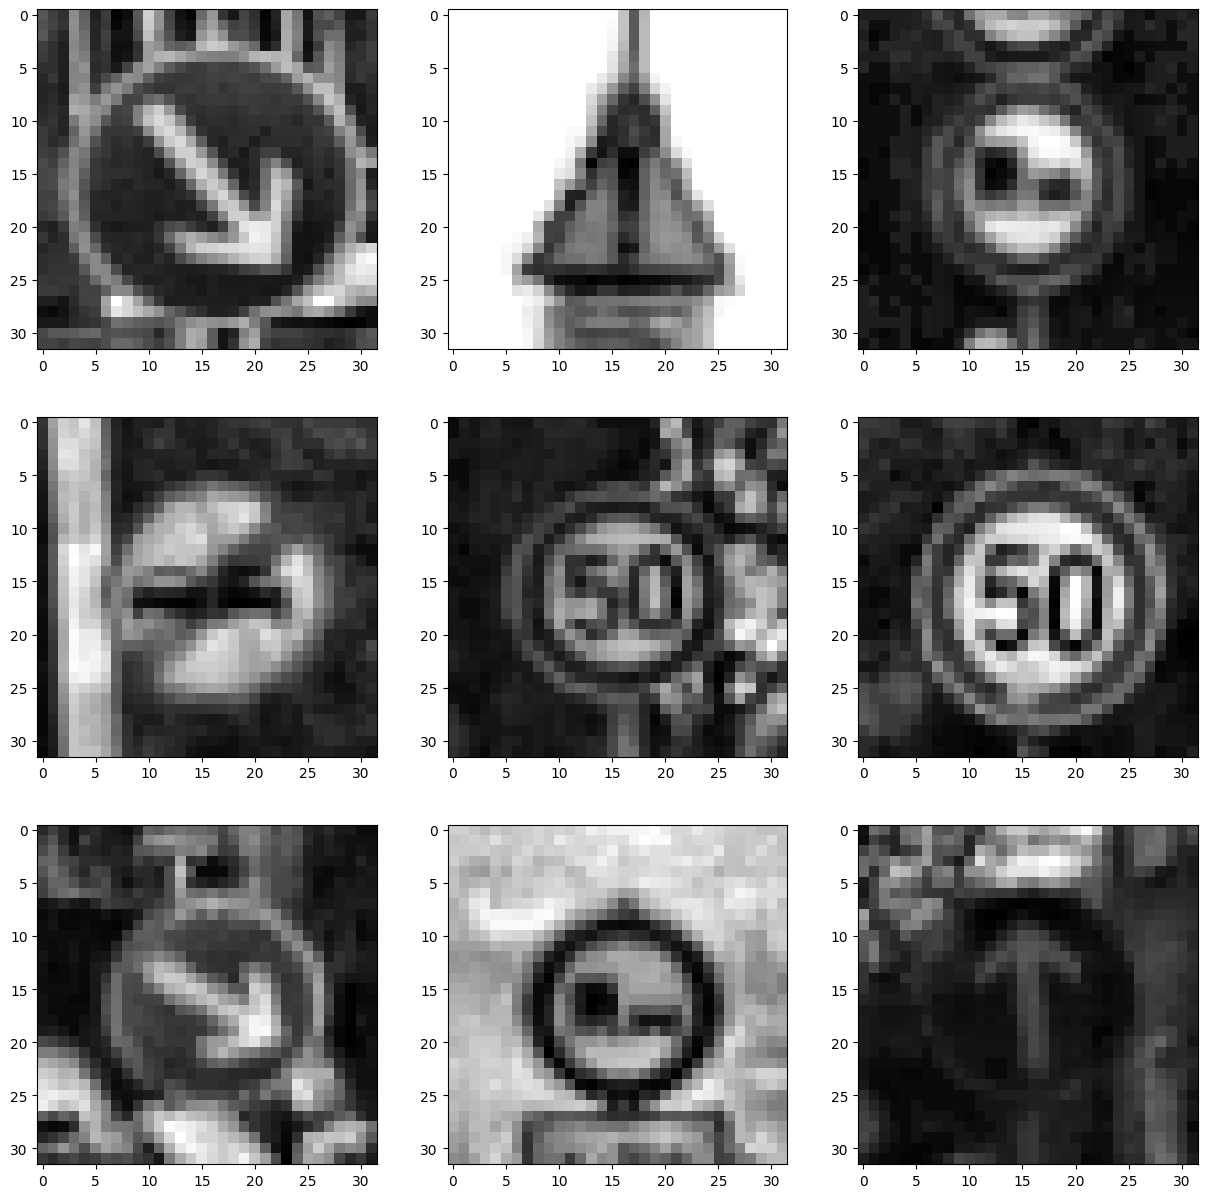

In [40]:
import cv2

class CLAHE:
    def __call__(self, image):
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4, 4))
        img = clahe.apply(img)
        img = img.reshape(img.shape + (1,))
        return img

class TORGB:
     def __call__(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_set_clahe = pickle.load(open("serialized_data/train_data_loader_clahe", "rb"))
test_set_clahe = pickle.load(open("serialized_data/test_data_loader_clahe", "rb"))

# Plotting random test set examples
plot_size = 3
random_idxs = [random.randint(0, len(test_set_clahe.dataset)) for i in range(plot_size**2)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_idxs):
    a=fig.add_subplot(plot_size,plot_size, i+1)
    imgplot = plt.imshow(test_set_clahe.dataset.__getitem__(index)[0].numpy().transpose(1,2,0), cmap='gray')
plt.show()

# 10. Model Comparison Post Data Preparation:

<a id="ap"></a>
### 11. Appendix:

Dataset Loader transforms and definitions: 

In [48]:
import torch
import torchvision.transforms as transforms 
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import cv2

class GTRSBDataset(Dataset):
    def __init__(self, csv_file, root_dir,img_size=32, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 7])
        image = cv2.imread(img_path)
        image = cv2.resize(image,(self.img_size,self.img_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        y_label = torch.tensor(int(self.annotations.iloc[index, 6]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [49]:

import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import os
import cv2
import numpy
import matplotlib.pyplot as plt
import cv2
batch_size = 256

class CLAHE:
    def __call__(self, image):
        img = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4, 4))
        img = clahe.apply(img)
        img = img.reshape(img.shape + (1,))
        return img

clahe_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor()
])

if not os.path.exists(os.getcwd() + os.sep + "serialized_data/"):
    os.makedirs(os.getcwd() + os.sep + "serialized_data/")

## CNN DATASETS

train_set = GTRSBDataset('data/train.csv','data',transform=transforms.ToTensor()) 
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
pickle.dump(train_loader, open("serialized_data/train_data_loader", "wb"))

test_set = GTRSBDataset('data/test.csv','data',transform=transforms.ToTensor()) 
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
pickle.dump(test_loader, open("serialized_data/test_data_loader", "wb"))

## ViT DATASETS

train_set_vit = GTRSBDataset('data/train.csv','data',img_size=128,transform=transforms.ToTensor()) 
train_loader_vit = DataLoader(dataset=train_set_vit, batch_size=batch_size, shuffle=True)
pickle.dump(train_loader_vit, open("serialized_data/train_data_loader_vit", "wb"))

test_set_vit = GTRSBDataset('data/test.csv','data',img_size=128,transform=transforms.ToTensor()) 
test_loader_vit = DataLoader(dataset=test_set_vit, batch_size=1, shuffle=False)
pickle.dump(test_loader_vit, open("serialized_data/test_data_loader_vit", "wb"))

## CLAHE DATASETS

train_set_clahe = GTRSBDataset('data/train.csv','data',transform=clahe_transforms) 
train_loader_clahe = DataLoader(dataset=train_set_clahe, batch_size=64, shuffle=True)
pickle.dump(train_loader_clahe, open("serialized_data/train_data_loader_clahe", "wb"))

test_set_clahe = GTRSBDataset('data/test.csv','data',transform=clahe_transforms) 
test_loader_clahe = DataLoader(dataset=test_set_clahe, batch_size=1, shuffle=False)
pickle.dump(test_loader_clahe, open("serialized_data/test_data_loader_clahe", "wb"))